<a href="https://colab.research.google.com/github/ivineetm007/Hypernetworks_tf2_keras/blob/master/HyperCNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import numpy as np
import os
from math import floor
# Load the keras layers and models
import cv2
from tqdm import tqdm
from keras.preprocessing import image
from tensorflow.keras.layers import Dense,Flatten,Softmax,ReLU,Input,Conv2D,MaxPool2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib 
from PIL import Image
import random
import matplotlib.pyplot as plt
print(device_lib.list_local_devices())
tf.keras.backend.set_floatx('float32')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13292090503907924025
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7042258349041571045
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1056632036087327325
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5710891999432013736
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Data Visualization

Image shape  (32, 32, 3)
Number of training examples 50000
Number of test examples 10000
uint8


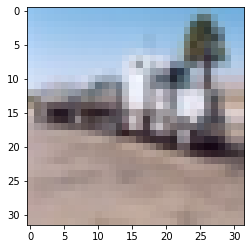

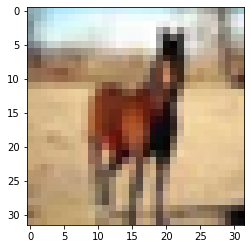

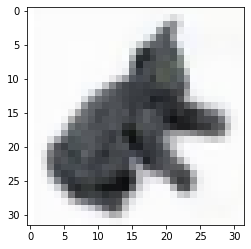

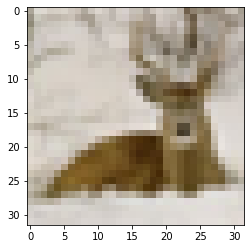

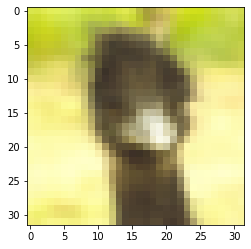

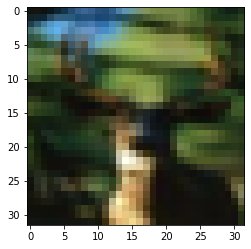

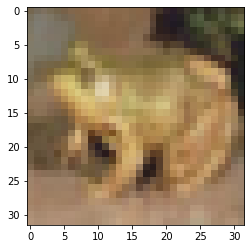

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("Image shape ",x_train[0].shape)
print('Number of training examples',len(x_train))
print('Number of test examples',len(x_test))
print(x_train.dtype)
res = [random.randrange(0, len(x_train), 1) for i in range(7)] 
for ind in res:
  fig = plt.figure()
  plt.imshow(x_train[ind])  

# Dataset Class 

In [0]:
# class to store mnist data and for data augmentation as suggested in paper.
class DataSet(object):
  def __init__(self, images, labels, augment=False):
    # Convert from [0, 255] -> [0.0, 1.0] -> [-1.0, 1.0]
    images = images.astype(np.float32)
    #images = images - 0.5
    #images = 2.0 * images
    self.image_size = 32
    self._num_examples = len(images)
    images = np.reshape(images, (self._num_examples, self.image_size, self.image_size, 3))
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = images[perm]/255
    self._labels = labels[perm]
    self._augment = augment
    self.pointer = 0
    self.upsize = 1 if self._augment else 0
    self.min_upsize = 4
    self.max_upsize = 4
    self.random_perm_mode=False
    self.num_classes = 10

  @property
  def images(self):
    return self._images
  @property
  def labels(self):
    return self._labels
  @property
  def num_examples(self):
    return self._num_examples

  def next_batch(self, batch_size=128, with_label = True, one_hot = False):
    if self.pointer >= self.num_examples-2*batch_size:
      self.pointer = 0
    else:
      self.pointer += batch_size
    result = []
    
    upsize_amount = np.random.randint(self.upsize*self.min_upsize, self.upsize*self.max_upsize+1)
    
    #def random_flip(x):
    #  if np.random.rand(1)[0] > 0.5:
    #    return np.fliplr(x)
    #  return x

    def upsize_row_once(img):
      old_size = img.shape[0]
      new_size = old_size+1
      new_img = np.zeros((new_size, img.shape[1], 3))
      rand_row = np.random.randint(1, old_size-1)
      new_img[0:rand_row,:] = img[0:rand_row,:,:]
      new_img[rand_row+1:,:] = img[rand_row:,:,:]
      new_img[rand_row,:,:] = 0.5*(new_img[rand_row-1,:,:]+new_img[rand_row+1,:,:])
      return new_img
    def upsize_col_once(img):
      old_size = img.shape[1]
      new_size = old_size+1
      new_img = np.zeros((img.shape[0], new_size, 3))
      rand_col = np.random.randint(1, old_size-1)
      new_img[:,0:rand_col,:] = img[:,0:rand_col,:]
      new_img[:,rand_col+1:,:] = img[:,rand_col:,:]
      new_img[:,rand_col,:] = 0.5*(new_img[:,rand_col-1,:]+new_img[:,rand_col+1,:])
      return new_img
    def upsize_me(img, n=self.max_upsize):
      new_img = img
      for i in range(n):
        new_img = upsize_row_once(new_img)
        new_img = upsize_col_once(new_img)
      # print(new_img.shape)
      return new_img

    for data in self._images[self.pointer:self.pointer+batch_size]:
      result.append(self.distort_image(upsize_me(data, upsize_amount), upsize_amount))
      
    if len(result) != batch_size:
      print("uh oh, self.pointer = ", self.pointer)
    assert(len(result) == batch_size)
    result_labels = self.labels[self.pointer:self.pointer+batch_size]
    assert(len(result_labels) == batch_size)
    if one_hot:
      result_labels = np.eye(self.num_classes)[result_labels]
    if with_label:
      return self.scramble_batch(np.array(result, dtype=np.float32)), result_labels
    return self.scramble_batch(np.array(result, dtype=np.float32))

  def distort_batch(self, batch, upsize_amount):
    batch_size = len(batch)
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1, batch_size)
    result = np.zeros(shape=(batch_size, self.image_size, self.image_size, 1), dtype=np.float32)
    for i in range(batch_size):
      result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+self.image_size, col_distort[i]:col_distort[i]+self.image_size, :]
    return result
  def scramble_batch(self, batch):
    if self.random_perm_mode:
      batch_size = len(batch)
      result = np.copy(batch)
      result = result.reshape(batch_size, self.image_size*self.image_size)
      result = result[:, self.random_key]
      return result
    else:
      result = batch
      return result
  def distort_image(self, img, upsize_amount):
    row_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    col_distort = np.random.randint(0, self.image_size+upsize_amount-self.image_size+1)
    result = np.zeros(shape=(self.image_size, self.image_size, 3), dtype=np.float32)
    result[:, :, :] = img[row_distort:row_distort+self.image_size, col_distort:col_distort+self.image_size, :]
    # print(result.shape)
    return result

  def shuffle_data(self):
    perm = np.arange(self._num_examples)
    np.random.shuffle(perm)
    self._images = self._images[perm]
    self._labels = self._labels[perm]

#Function to create dataset classes for train,val and test
def read_data_sets(train_data,train_labels,val_data,val_labels,test_data,test_labels):

  class DataSets(object):
    pass
  data_sets = DataSets()

  data_sets.train = DataSet(train_data,train_labels, augment=True)
  data_sets.valid = DataSet(val_data,val_labels, augment=False)
  data_sets.test = DataSet(test_data,test_labels, augment=False)
  # XDIM = data_sets.train.image_size
  #random_key = np.random.permutation(XDIM*XDIM)
  #data_sets.train.random_key = random_key
  #data_sets.valid.random_key = random_key
  #data_sets.test.random_key = random_key
  return data_sets

# Hypernetwork and Layer

In [0]:
'''
Paper Notation
Nz= embedding_dim
D=
Nin=
Nout=
f=

Input=(1,Nz)
Output=(f, f, Nin, Nout)

Build- 
'''
class HyperNetwork(tf.keras.Model):
  def __init__(self, Nz, D , Nin,Nout,f):
    super(HyperNetwork, self).__init__()
    self.emb_dim=Nz
    self.hidden_dim=D
    self.filter_size=f
    self.input_channels=Nin
    self.output_channels=Nout
    self.hidden_dense_layers=[Dense(D, input_shape=(None,Nz),kernel_initializer='TruncatedNormal',name='hyper_dense'+str(i)) for i in range(Nin)]#initializer default value is used can be given input
    self.final_layer=Dense(Nout*f*f, input_shape=(None,D),kernel_initializer='TruncatedNormal',name='hyper_shared_dense')
  def call(self, emb):
    weights=[]
    for i in range(self.input_channels):
      #dim- None,D
      hidden=self.hidden_dense_layers[i](emb)
      #dim- None,1,Nout*f*f
      weights.append(tf.expand_dims(self.final_layer(hidden),1))
    final_weights=tf.reshape(tf.concat(weights,1),( -1,self.filter_size, self.filter_size, self.input_channels,self.output_channels))
    return final_weights

'''
Functionality- 
  Take hypernetwork as input and create weights for the conv layer. 
  Train embeddings for the layer.
Init
  emb_dim
  kernel dimensions
Build
Call
'''
class HyperConvLayer(tf.keras.layers.Layer):
  def __init__(self,hyper_net,input_channels=16,output_channels=16,padding='same', activation='relu',**kwargs):
    super(HyperConvLayer, self).__init__(**kwargs)
    self.hyper_net=hyper_net
    self.input_channels=input_channels
    self.output_channels=output_channels

    # Assumption [h,w] as input given to Conv layer
    self.filter_size=self.hyper_net.filter_size
    self.emb_dim=self.hyper_net.emb_dim
    self.padding=padding
    self.activation=activation
    assert(self.input_channels%self.hyper_net.input_channels==0)
    assert(self.output_channels%self.hyper_net.output_channels==0)
    self.emb_num=int((self.input_channels/self.hyper_net.input_channels)*(self.output_channels/self.hyper_net.output_channels))
  def build(self,input_shape):
    '''
    check the 2.0 code to add weight
    https://github.com/tensorflow/tensorflow/blob/r2.0/tensorflow/python/keras/engine/base_layer.py#L86-L2422
    '''
    self.emb= self.add_weight(name="emb",shape= [self.emb_num, self.emb_dim],dtype='float64', initializer=tf.keras.initializers.TruncatedNormal(0.01))
 

    
  # def get_config(self):
  #   config = super(HyperConvLayer, self).get_config()
  #   config.update({'emb_dim': self.emd_dim })
  #   config.update({'input_channels': self.input_channels })
  #   config.update({'output_channels': self.output_channels })
  #   config.update({'filter_size': self.filter_size })
  #   config.update({'hyper_net_channels': self.hyper_net_channels})
  #   config.update({'emb_num': self.emb_num})
  #   return config
  
  def call(self,input):
    conv_weights=self.hyper_net(self.emb)
    conv_weights=tf.reshape(conv_weights,(self.filter_size,self.filter_size,self.input_channels,self.output_channels))
    if self.activation=='relu':
      return tf.nn.relu(tf.nn.conv2d(input, conv_weights, strides=[1, 1, 1, 1], padding=self.padding))
    #dim None,f,f,Nin,Nout -> filter_width,filter_height,Nin,Nout



# Training and Tesing Code

In [0]:
from sklearn.metrics import accuracy_score
def get_accuracy(y_true, y_prob):
  y_pred=np.argmax(y_prob,axis=1)
  return accuracy_score(y_true, y_pred)

'''
FUnction to plot sigle graph
'''
def save_graph(x,x_label='Epochs',y_label='Loss',title='Loss Plot',path=''):
  plt.plot(x)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.savefig(path)
  plt.show()


def save_multiple_graph(x_list,labels=['train','val'],x_label='Epochs',y_label='Loss',title='Loss Plot',path=''):
  
  x=[i+1 for i in range(len(x_list[0]))]
  for i,(y,label) in enumerate(zip(x_list,labels)):
    plt.plot(x,y,label=label)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend()
  plt.savefig(path)
  plt.show()
'''
Train given model, early stop on val, test score, losses and validation accuracy graph
'''
def train_model(model,datasets,train_param):
  loss_function = tf.keras.losses.CategoricalCrossentropy()
  batch_size=train_param.batch_size
  exppath=train_param.path

  @tf.function
  def train_batch(img,labels):
    loss=0
    with tf.GradientTape() as tape:
      probs = model(img)
      loss = loss_function(labels, probs)


    trainable_variables = model.trainable_variables 

    gradients = tape.gradient(loss, trainable_variables)

    train_param.optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

  # Parameters and path
  num_examples = datasets.train.num_examples
  total_batch = int(num_examples / batch_size)
  losses=[]
  val_acc=[]
  train_acc=[]
  best_val_acc=0
  start_epoch=-1
  epochpath=exppath+'epoch.npy'
  losspath=exppath+'loss.npy'
  valpath=exppath+'val.npy'
  best_acc_path=exppath+'best_val_acc.npy'
  modelpath=exppath+'model.h5'
  bestmodelpath=exppath+'best_model.h5'
  loss_graph_path=exppath+'loss.png'
  val_graph_path=exppath+'acc.png'
  train_acc_path=exppath+'train.npy'

  if os.path.isfile(best_acc_path):
    best_val_acc=np.load(best_acc_path)
  if os.path.isfile(epochpath):
    start_epoch=np.load(epochpath)
  if os.path.isfile(losspath):
    losses=list(np.load(losspath))
  if os.path.isfile(valpath):
    val_acc=list(np.load(valpath))
  if os.path.isfile(train_acc_path):
    train_acc=list(np.load(train_acc_path))
  if os.path.isfile(modelpath):
    #passing image to build
    _=model(datasets.valid.images[0:1,:])
    model.load_weights(modelpath)
  # Training
  epoch=start_epoch
  for epoch in range(start_epoch+1,train_param.num_epochs):
    epoch_loss=0
    batch_loss=0

    #Saving model summary
    if epoch==1:
        #Saving model summary
      from contextlib import redirect_stdout
      with open(exppath+'modelsummary.txt', 'w') as f:
        with redirect_stdout(f):
          model.summary()
        
    for i in range(total_batch):
      batch_images, batch_labels = datasets.train.next_batch(batch_size, with_label = True, one_hot = True)
      batch_loss+=train_batch(batch_images, batch_labels)
    epoch_loss=batch_loss/total_batch
    losses.append(epoch_loss)
    val_accuracy=get_accuracy(datasets.valid.labels, model(datasets.valid.images))
    val_acc.append(val_accuracy)
    train_accuracy=get_accuracy(datasets.train.labels[:5000], model(datasets.train.images[:5000]))
    train_acc.append(train_accuracy)
    print ('Epoch {} Loss {:.4f} Train Accuracy {:.4f} Val Accuracy {:.4f}'.format(
              epoch , epoch_loss,train_accuracy ,val_accuracy ))
    #Saving stats at each fifth epoch
    if epoch%5==0:
      np.save(losspath,losses)
      np.save(epochpath,epoch)
      np.save(valpath,val_acc)
      np.save(train_acc_path,train_acc)
      model.save_weights(modelpath)
    if val_accuracy>best_val_acc:
      np.save(best_acc_path,best_val_acc)
      model.save_weights(bestmodelpath)
  
  #saving all 
  np.save(losspath,losses)
  np.save(epochpath,epoch)
  np.save(valpath,val_acc)
  np.save(train_acc_path,train_acc)
  print("Best validation accuracy",max(val_acc))
  model.summary()
  save_graph(losses,x_label='Epochs',y_label='Loss',title='Loss Plot',path=loss_graph_path)
  save_multiple_graph([val_acc,train_acc],labels=['val','train'],x_label='Epochs',y_label='Accuracy',title='Accuracy Plot',path=val_graph_path)


class train_parameters(object):
  def __init__(self,batch_size=100,num_epochs=50,optimizer='adam',learning_rate=0.005,rate_decay=0.999,savepath=''):
    self.batch_size=batch_size
    self.num_epochs=num_epochs
    self.learning_rate=learning_rate
    self.rate_decay=rate_decay
    self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,decay_rate=self.rate_decay,decay_steps=1,staircase=False)
    if optimizer=='adam':
      self.optimizer=tf.keras.optimizers.Adam(learning_rate=self.lr_schedule)
    elif optimizer=='sgd':
      self.optimizer=tf.keras.optimizers.SGD(learning_rate=self.lr_schedule)
    self.path=savepath




In [0]:
'''
Save classification report
'''
def test_report(model,datasets,train_param):
  #loading best model
  model.load_weights(train_param.path+'best_model.h5')
  y_pred=np.argmax(model(datasets.test.images),axis=1)
  y_true=datasets.test.labels 
  from sklearn.metrics import classification_report,accuracy_score
  report=classification_report(y_true, y_pred, digits=4)
  print(report)
  score= accuracy_score(y_true, y_pred)
  print("Test accuracy {:.4f}".format(score ))
  from contextlib import redirect_stdout
  with open(train_param.path+'testreport.txt', 'w') as f:
    with redirect_stdout(f):
      print(report)
      print("\nTest accuracy {:.4f}".format(score ))


# First Architecture- One VGG Block
conv 16 3,3 \\
conv 16 3,3 \\
max pool 2,2 \\
dropout 0.4 \\
dense 128 \\
dropout 0.5 \\
dense 10

# Conv net

In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class ConvModel(tf.keras.Model):
  def __init__(self,filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=32,dropout=0.5):
    super(ConvModel, self).__init__()
    self.num_class=num_class
    self.filter_size=filter_size
    
    #First Conv Block 
    self.conv1_1_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=0.4)    

    self.flatten_layer=Flatten()
    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout2_layer=Dropout(rate=dropout)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_layer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    flatten=self.flatten_layer(dropout1_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout2_outputs=self.dropout2_layer(dense1_outputs)
    prob=self.final_layer(dropout2_outputs)
    return prob

In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block1'
name='convmodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

batch_size_list=[128]
dropout_rates=[0.3,0.5,0.7]
optimizers={'adam':[0.001,0.003,0.005]}
epochs=50

------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  128
adam  Optimizer initial rate  0.001
Dropout  0.3
------------------------------------
Training....
------------------------------------
Best validation accuracy 0.6584
Model: "conv_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_conv1_1 (Conv2D)        multiple                  448       
_________________________________________________________________
main_conv1_2 (Conv2D)        multiple                  2320      
_________________________________________________________________
main_batch1 (BatchNormalizat multiple                  64        
_________________________________________________________________
main_max1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
dropou

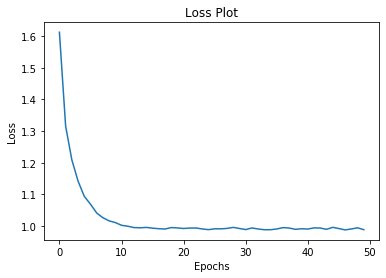

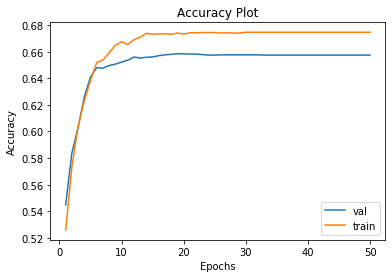

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6720    0.7130    0.6919      1000
           1     0.7390    0.7900    0.7637      1000
           2     0.5480    0.4850    0.5146      1000
           3     0.5146    0.3890    0.4431      1000
           4     0.6148    0.5490    0.5800      1000
           5     0.5817    0.5480    0.5644      1000
           6     0.6082    0.8320    0.7027      1000
           7     0.7341    0.7290    0.7316      1000
           8     0.7557    0.7670    0.7613      1000
           9     0.6906    0.7030    0.6967      1000

    accuracy                         0.6505     10000
   macro avg     0.6459    0.6505    0.6450     10000
weighted avg     0.6459    0.6505    0.6450     10000

Test accuracy 0.6505
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

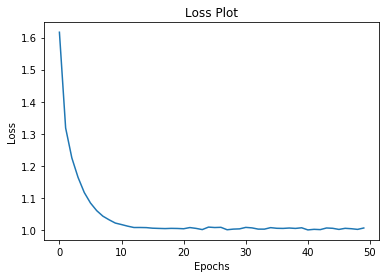

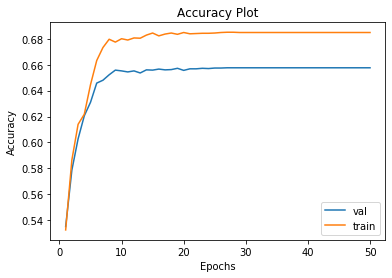

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6482    0.7370    0.6898      1000
           1     0.7246    0.7840    0.7531      1000
           2     0.5184    0.4930    0.5054      1000
           3     0.5259    0.3650    0.4309      1000
           4     0.6443    0.5090    0.5687      1000
           5     0.5703    0.5560    0.5630      1000
           6     0.5904    0.8520    0.6975      1000
           7     0.7133    0.7290    0.7211      1000
           8     0.7518    0.7300    0.7407      1000
           9     0.7294    0.6820    0.7049      1000

    accuracy                         0.6437     10000
   macro avg     0.6417    0.6437    0.6375     10000
weighted avg     0.6417    0.6437    0.6375     10000

Test accuracy 0.6437
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

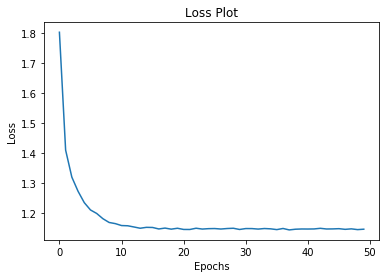

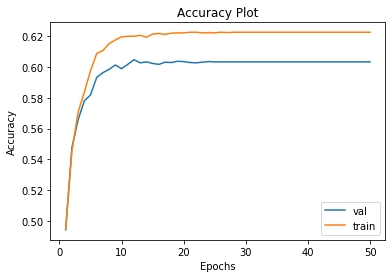

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6296    0.6630    0.6459      1000
           1     0.6679    0.7180    0.6920      1000
           2     0.5076    0.4350    0.4685      1000
           3     0.4893    0.3650    0.4181      1000
           4     0.5699    0.4810    0.5217      1000
           5     0.5589    0.5170    0.5371      1000
           6     0.5901    0.7760    0.6704      1000
           7     0.6610    0.6980    0.6790      1000
           8     0.7019    0.7230    0.7123      1000
           9     0.6215    0.6830    0.6508      1000

    accuracy                         0.6059     10000
   macro avg     0.5998    0.6059    0.5996     10000
weighted avg     0.5998    0.6059    0.5996     10000

Test accuracy 0.6059
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

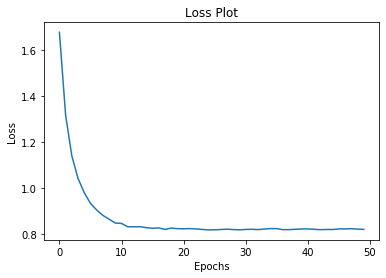

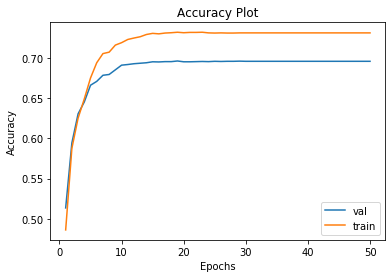

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6930    0.7720    0.7304      1000
           1     0.7766    0.8170    0.7963      1000
           2     0.5924    0.5160    0.5516      1000
           3     0.5208    0.4140    0.4613      1000
           4     0.6383    0.5840    0.6099      1000
           5     0.5840    0.6190    0.6010      1000
           6     0.6680    0.8270    0.7391      1000
           7     0.7319    0.7590    0.7452      1000
           8     0.8247    0.7670    0.7948      1000
           9     0.7530    0.7440    0.7485      1000

    accuracy                         0.6819     10000
   macro avg     0.6783    0.6819    0.6778     10000
weighted avg     0.6783    0.6819    0.6778     10000

Test accuracy 0.6819
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

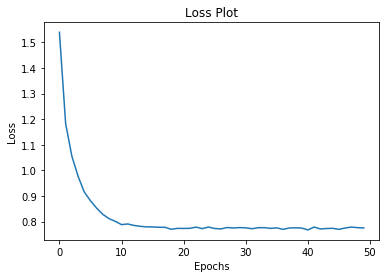

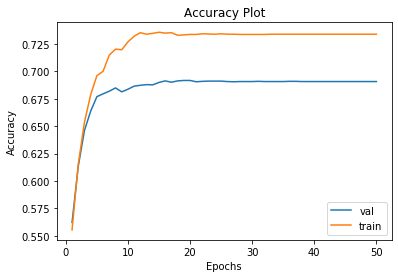

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6944    0.7500    0.7212      1000
           1     0.7639    0.8410    0.8006      1000
           2     0.5923    0.5260    0.5572      1000
           3     0.5814    0.4250    0.4910      1000
           4     0.6559    0.5910    0.6218      1000
           5     0.6199    0.5790    0.5988      1000
           6     0.5881    0.8910    0.7085      1000
           7     0.7670    0.7340    0.7501      1000
           8     0.8310    0.7870    0.8084      1000
           9     0.7896    0.7470    0.7677      1000

    accuracy                         0.6871     10000
   macro avg     0.6884    0.6871    0.6825     10000
weighted avg     0.6884    0.6871    0.6825     10000

Test accuracy 0.6871
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

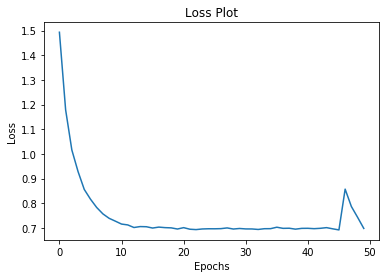

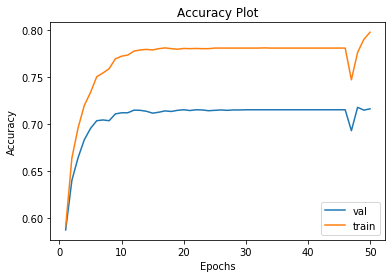

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7126    0.7810    0.7452      1000
           1     0.8224    0.8290    0.8257      1000
           2     0.6836    0.5250    0.5939      1000
           3     0.6161    0.4350    0.5100      1000
           4     0.6694    0.6580    0.6636      1000
           5     0.6291    0.6260    0.6276      1000
           6     0.6235    0.8860    0.7319      1000
           7     0.7532    0.7660    0.7595      1000
           8     0.8307    0.7900    0.8098      1000
           9     0.7668    0.8090    0.7873      1000

    accuracy                         0.7105     10000
   macro avg     0.7108    0.7105    0.7055     10000
weighted avg     0.7108    0.7105    0.7055     10000

Test accuracy 0.7105
------------------------------------
VGG Block 1 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

KeyboardInterrupt: ignored

In [0]:

  #Hyperparameters tuning on learning rate,batch size
for optimizer,rates in optimizers.items():
  for rate in rates:
    for batch_size in batch_size_list:
      for dropout in dropout_rates:
        print("------------------------------------")
        print("VGG Block 1 training")
        print("------------------------------------")
        print("ConvModel Training")
        print("HyperParameters")
        print("Batch size ",batch_size)
        print(optimizer," Optimizer initial rate ",rate)
        print("Dropout ",dropout)
        #datasets initialization
        CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
        exppath=path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
        os.makedirs(exppath,exist_ok=True)    
        # Model initialization
        model=ConvModel(filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=16,dropout=dropout)
        train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
        print("------------------------------------")
        print("Training....")
        print("------------------------------------")
        train_model(model,CIFAR,train_param)
        print("Test report saved in MNIST folder and subfolder named as per parameters....")
        test_report(model,CIFAR,train_param)      

## Hyper Model 
Base hyper network- 3 into 3 and 16 into 16 channels base 



In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class HyperModel(tf.keras.Model):
  def __init__(self,emb_dim=4,emb_proj_dim=4,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=0.5):
    super(HyperModel, self).__init__()
    self.emb_dim=emb_dim
    self.emb_proj_dim=emb_proj_dim
    self.num_class=num_class
    self.base_channels=base_channels
    self.filter_size=filter_size
    # Hypernetwork
    self.hnet=HyperNetwork( Nz=emb_dim, D=emb_proj_dim , Nin=self.base_channels,Nout=self.base_channels,f=self.filter_size)
    self.hnet.build(input_shape=(None, emb_dim))
  
    #First Conv Block 
    self.conv1_1_layer = Conv2D(self.base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=16,output_channels=16,padding='SAME', activation='relu',name='hyper_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=dropout)    

    self.flatten_layer=Flatten()
    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout2_layer=Dropout(rate=0.5)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')
    
    
    
    

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_hlayer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    flatten=self.flatten_layer(dropout1_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout2_outputs=self.dropout2_layer(dense1_outputs)
    prob=self.final_layer(dropout2_outputs)
    return prob


In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block1'
name='hypermodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

emb_proj_list=[(4,4),(6,6),(8,8),(4,5),(4,6),(4,7)]
batch_size_list=[128]
dropout_rates=[0.5]
optimizers={'adam':[0.001,0.002,0.003,0.0008]}
epochs=50


------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection Embedding size  4
HyperParameters
Batch size  128
Dropout  0.5
adam  Optimizer initial rate  0.001
------------------------------------
Training....
------------------------------------
Best validation accuracy 0.5524
Model: "hyper_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hyper_network_1 (HyperNetwor multiple                  1040      
_________________________________________________________________
main_conv1_1 (Conv2D)        multiple                  448       
_________________________________________________________________
hyper_conv1_2 (HyperConvLaye multiple                  1044      
_________________________________________________________________
main_batch1 (BatchNormalizat multiple                  64        
_____________________

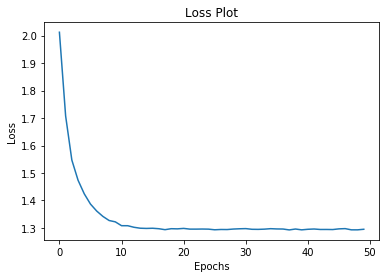

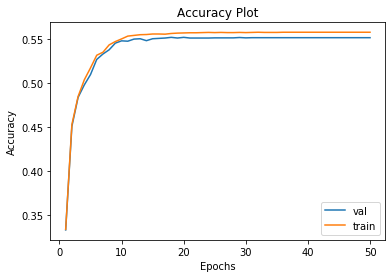

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5819    0.6250    0.6027      1000
           1     0.5956    0.6790    0.6346      1000
           2     0.4749    0.4060    0.4377      1000
           3     0.4215    0.2550    0.3178      1000
           4     0.4959    0.4200    0.4548      1000
           5     0.4545    0.4390    0.4466      1000
           6     0.5441    0.6730    0.6017      1000
           7     0.5587    0.6570    0.6039      1000
           8     0.6452    0.6820    0.6631      1000
           9     0.5810    0.6060    0.5932      1000

    accuracy                         0.5442     10000
   macro avg     0.5353    0.5442    0.5356     10000
weighted avg     0.5353    0.5442    0.5356     10000

Test accuracy 0.5442
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

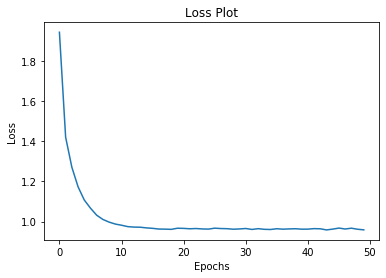

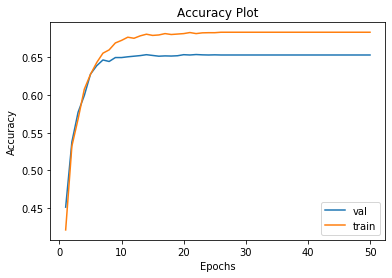

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6619    0.7480    0.7023      1000
           1     0.7493    0.7710    0.7600      1000
           2     0.5638    0.4860    0.5220      1000
           3     0.5116    0.3750    0.4328      1000
           4     0.6249    0.5580    0.5895      1000
           5     0.5508    0.5370    0.5438      1000
           6     0.6309    0.8000    0.7055      1000
           7     0.6886    0.7210    0.7044      1000
           8     0.7564    0.7670    0.7617      1000
           9     0.6902    0.7240    0.7067      1000

    accuracy                         0.6487     10000
   macro avg     0.6428    0.6487    0.6429     10000
weighted avg     0.6428    0.6487    0.6429     10000

Test accuracy 0.6487
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

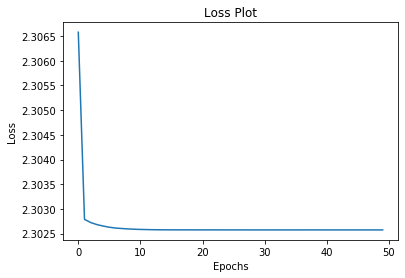

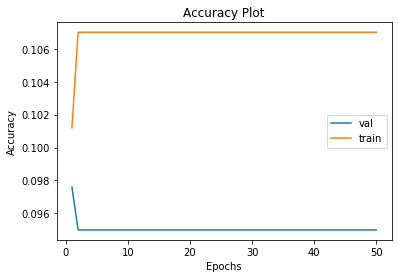

Test report saved in MNIST folder and subfolder named as per parameters....


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.1000    1.0000    0.1818      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection Embedding size  4
HyperParameters
Batch size  128
Dropout  0.5
adam  Optimiz

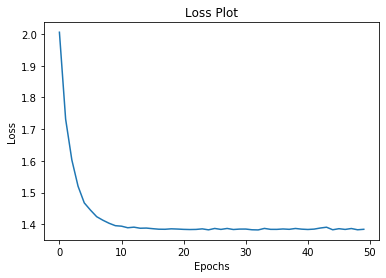

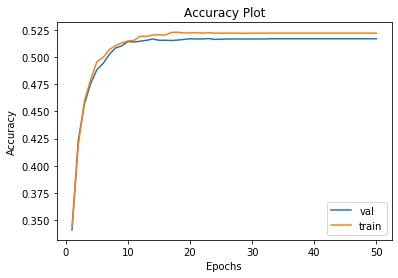

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5600    0.6110    0.5844      1000
           1     0.5584    0.6740    0.6108      1000
           2     0.4406    0.3930    0.4154      1000
           3     0.4294    0.2890    0.3455      1000
           4     0.4682    0.4120    0.4383      1000
           5     0.4822    0.3930    0.4331      1000
           6     0.5273    0.6470    0.5811      1000
           7     0.5193    0.5910    0.5529      1000
           8     0.5980    0.6500    0.6229      1000
           9     0.5475    0.5420    0.5447      1000

    accuracy                         0.5202     10000
   macro avg     0.5131    0.5202    0.5129     10000
weighted avg     0.5131    0.5202    0.5129     10000

Test accuracy 0.5202
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  6
Projection 

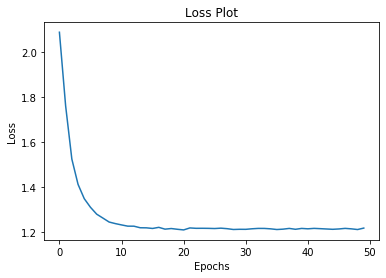

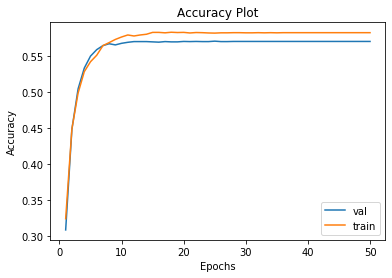

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5874    0.6620    0.6225      1000
           1     0.6602    0.7150    0.6865      1000
           2     0.4873    0.3850    0.4302      1000
           3     0.4498    0.2870    0.3504      1000
           4     0.5021    0.4680    0.4845      1000
           5     0.5234    0.4700    0.4953      1000
           6     0.5402    0.6720    0.5989      1000
           7     0.5644    0.6530    0.6055      1000
           8     0.7180    0.6950    0.7063      1000
           9     0.5589    0.6500    0.6010      1000

    accuracy                         0.5657     10000
   macro avg     0.5592    0.5657    0.5581     10000
weighted avg     0.5592    0.5657    0.5581     10000

Test accuracy 0.5657
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  6
Projection 

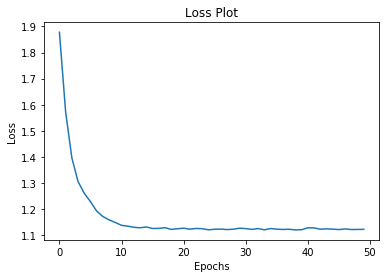

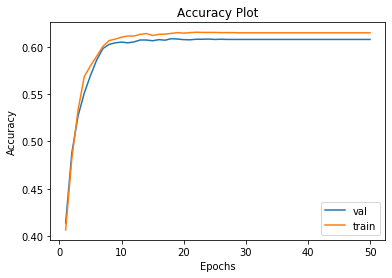

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6115    0.6800    0.6439      1000
           1     0.6806    0.7180    0.6988      1000
           2     0.5633    0.4450    0.4972      1000
           3     0.4915    0.3450    0.4054      1000
           4     0.5572    0.4820    0.5169      1000
           5     0.5319    0.5170    0.5243      1000
           6     0.6093    0.7360    0.6667      1000
           7     0.6221    0.7080    0.6623      1000
           8     0.7079    0.7270    0.7173      1000
           9     0.5818    0.6580    0.6176      1000

    accuracy                         0.6016     10000
   macro avg     0.5957    0.6016    0.5950     10000
weighted avg     0.5957    0.6016    0.5950     10000

Test accuracy 0.6016
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  6
Projection 

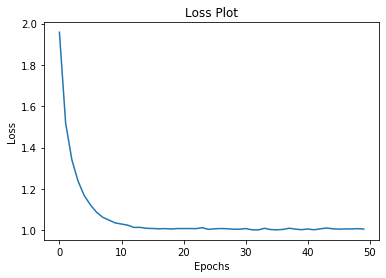

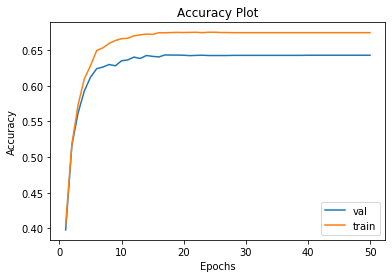

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6474    0.6960    0.6708      1000
           1     0.7231    0.7860    0.7532      1000
           2     0.5469    0.4960    0.5202      1000
           3     0.4949    0.3370    0.4010      1000
           4     0.6048    0.5510    0.5767      1000
           5     0.5565    0.5420    0.5491      1000
           6     0.6167    0.8030    0.6977      1000
           7     0.6877    0.7200    0.7035      1000
           8     0.7387    0.7490    0.7438      1000
           9     0.7006    0.7020    0.7013      1000

    accuracy                         0.6382     10000
   macro avg     0.6317    0.6382    0.6317     10000
weighted avg     0.6317    0.6382    0.6317     10000

Test accuracy 0.6382
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  6
Projection 

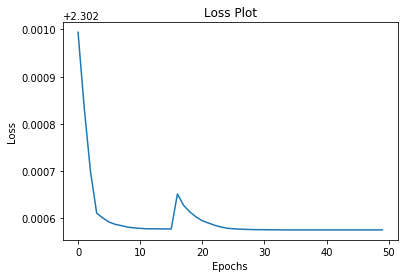

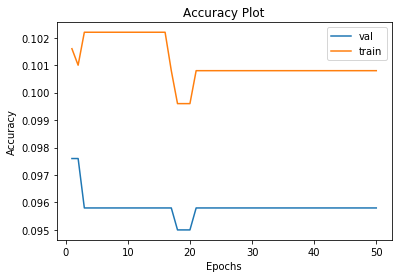

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.1000    1.0000    0.1818      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.0000    0.0000    0.0000      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  8
Projection 

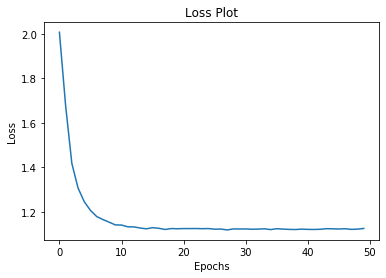

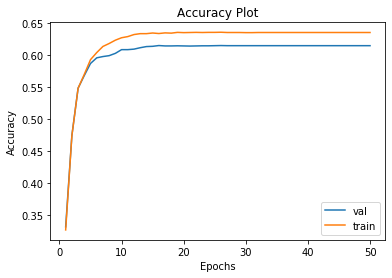

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6203    0.6830    0.6502      1000
           1     0.6800    0.7140    0.6966      1000
           2     0.5296    0.4300    0.4746      1000
           3     0.4891    0.3600    0.4147      1000
           4     0.5803    0.4950    0.5343      1000
           5     0.5219    0.5240    0.5230      1000
           6     0.6220    0.7470    0.6788      1000
           7     0.6132    0.6690    0.6399      1000
           8     0.7151    0.7480    0.7312      1000
           9     0.6076    0.6720    0.6382      1000

    accuracy                         0.6042     10000
   macro avg     0.5979    0.6042    0.5981     10000
weighted avg     0.5979    0.6042    0.5981     10000

Test accuracy 0.6042
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  8
Projection 

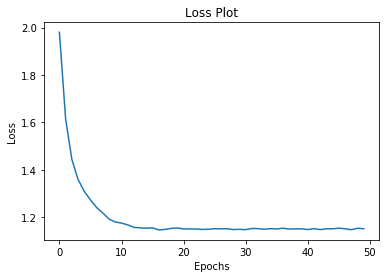

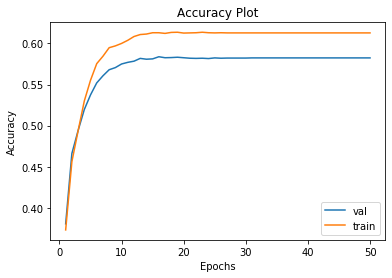

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5957    0.6690    0.6302      1000
           1     0.6463    0.7400    0.6900      1000
           2     0.5156    0.4290    0.4683      1000
           3     0.4727    0.3290    0.3880      1000
           4     0.5358    0.4710    0.5013      1000
           5     0.5069    0.4780    0.4920      1000
           6     0.5912    0.7230    0.6505      1000
           7     0.6004    0.6760    0.6359      1000
           8     0.6855    0.6910    0.6882      1000
           9     0.6029    0.6180    0.6104      1000

    accuracy                         0.5824     10000
   macro avg     0.5753    0.5824    0.5755     10000
weighted avg     0.5753    0.5824    0.5755     10000

Test accuracy 0.5824
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  8
Projection 

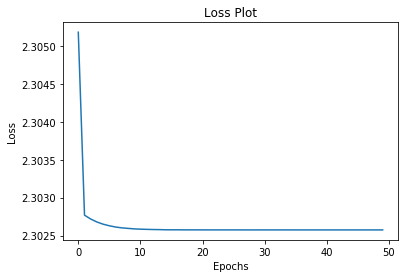

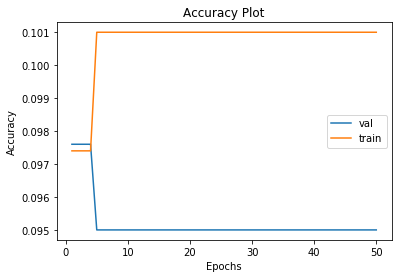

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.1000    1.0000    0.1818      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  8
Projection 

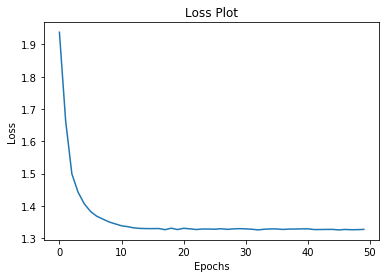

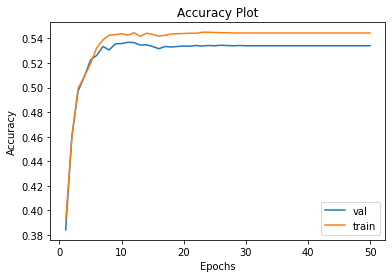

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5554    0.6320    0.5912      1000
           1     0.5911    0.6910    0.6372      1000
           2     0.4577    0.3900    0.4212      1000
           3     0.4330    0.2910    0.3481      1000
           4     0.5187    0.4300    0.4702      1000
           5     0.4701    0.4090    0.4374      1000
           6     0.5328    0.6910    0.6017      1000
           7     0.5562    0.6140    0.5837      1000
           8     0.6183    0.6610    0.6390      1000
           9     0.5650    0.5650    0.5650      1000

    accuracy                         0.5374     10000
   macro avg     0.5298    0.5374    0.5295     10000
weighted avg     0.5298    0.5374    0.5295     10000

Test accuracy 0.5374
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

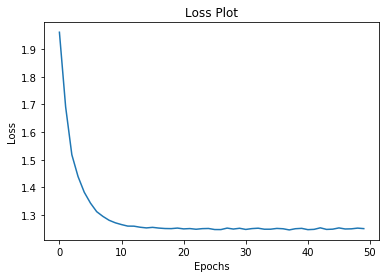

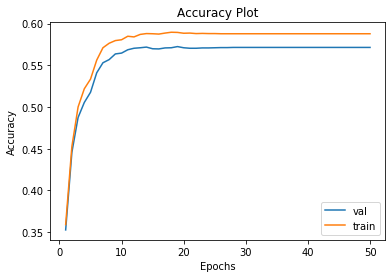

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6047    0.6210    0.6127      1000
           1     0.6461    0.7210    0.6815      1000
           2     0.4988    0.4020    0.4452      1000
           3     0.4310    0.3030    0.3558      1000
           4     0.5203    0.4220    0.4660      1000
           5     0.4867    0.4560    0.4708      1000
           6     0.5404    0.7220    0.6182      1000
           7     0.5858    0.6450    0.6140      1000
           8     0.6483    0.6820    0.6647      1000
           9     0.5725    0.6360    0.6026      1000

    accuracy                         0.5610     10000
   macro avg     0.5535    0.5610    0.5532     10000
weighted avg     0.5535    0.5610    0.5532     10000

Test accuracy 0.5610
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

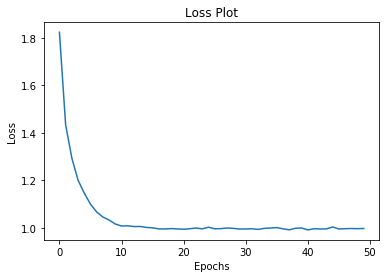

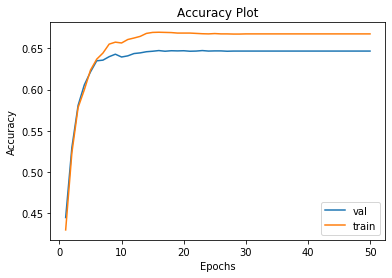

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6334    0.7240    0.6757      1000
           1     0.7142    0.7820    0.7465      1000
           2     0.5371    0.4990    0.5174      1000
           3     0.4693    0.3510    0.4016      1000
           4     0.6406    0.5170    0.5722      1000
           5     0.5505    0.5070    0.5279      1000
           6     0.5649    0.8490    0.6784      1000
           7     0.7306    0.6590    0.6930      1000
           8     0.7352    0.7440    0.7396      1000
           9     0.7223    0.6790    0.7000      1000

    accuracy                         0.6311     10000
   macro avg     0.6298    0.6311    0.6252     10000
weighted avg     0.6298    0.6311    0.6252     10000

Test accuracy 0.6311
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

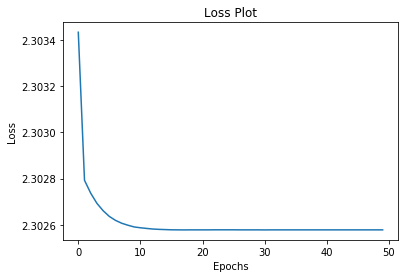

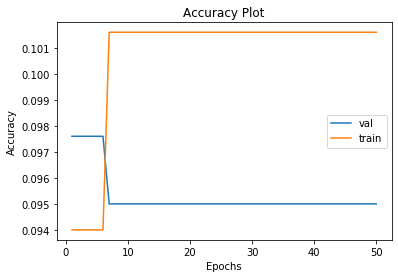

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.1000    1.0000    0.1818      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

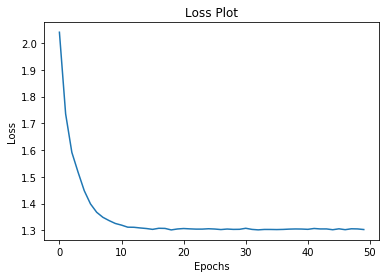

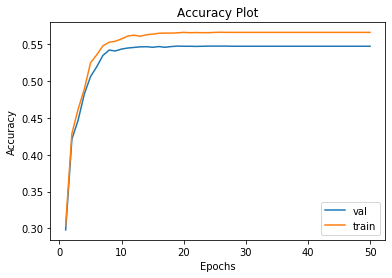

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5753    0.6150    0.5945      1000
           1     0.6203    0.6860    0.6515      1000
           2     0.4771    0.4060    0.4387      1000
           3     0.4579    0.3100    0.3697      1000
           4     0.4923    0.4470    0.4686      1000
           5     0.4908    0.4290    0.4578      1000
           6     0.5317    0.6550    0.5869      1000
           7     0.5398    0.6310    0.5818      1000
           8     0.6742    0.6830    0.6786      1000
           9     0.5450    0.6000    0.5712      1000

    accuracy                         0.5462     10000
   macro avg     0.5404    0.5462    0.5399     10000
weighted avg     0.5404    0.5462    0.5399     10000

Test accuracy 0.5462
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

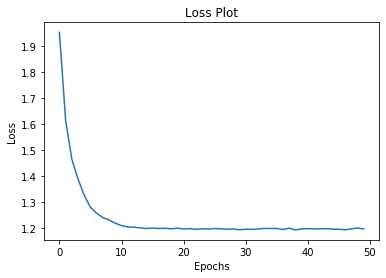

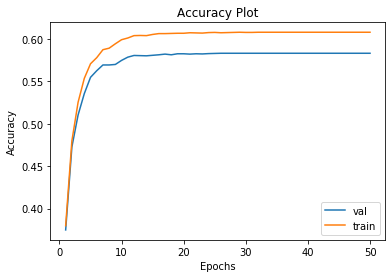

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.5855    0.6710    0.6253      1000
           1     0.6664    0.7110    0.6880      1000
           2     0.4723    0.4270    0.4485      1000
           3     0.4769    0.3310    0.3908      1000
           4     0.5449    0.4730    0.5064      1000
           5     0.5458    0.4770    0.5091      1000
           6     0.5587    0.7470    0.6393      1000
           7     0.6145    0.6360    0.6251      1000
           8     0.6811    0.7070    0.6938      1000
           9     0.6037    0.6260    0.6146      1000

    accuracy                         0.5806     10000
   macro avg     0.5750    0.5806    0.5741     10000
weighted avg     0.5750    0.5806    0.5741     10000

Test accuracy 0.5806
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

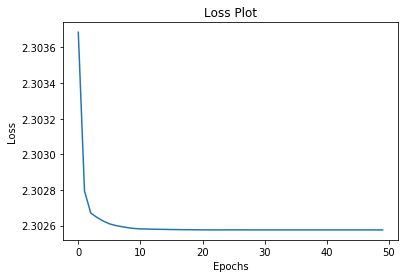

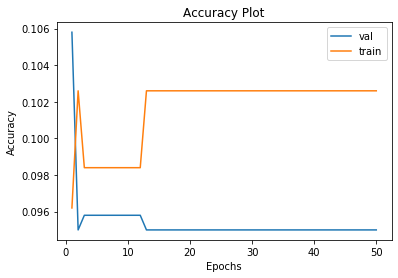

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.1000    1.0000    0.1818      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

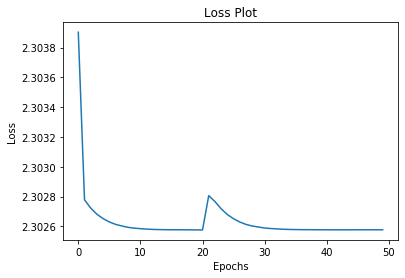

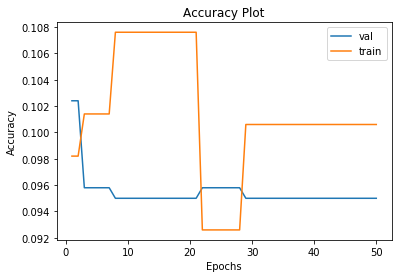

Test report saved in MNIST folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1000
           1     0.0000    0.0000    0.0000      1000
           2     0.0000    0.0000    0.0000      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.1000    1.0000    0.1818      1000
           5     0.0000    0.0000    0.0000      1000
           6     0.0000    0.0000    0.0000      1000
           7     0.0000    0.0000    0.0000      1000
           8     0.0000    0.0000    0.0000      1000
           9     0.0000    0.0000    0.0000      1000

    accuracy                         0.1000     10000
   macro avg     0.0100    0.1000    0.0182     10000
weighted avg     0.0100    0.1000    0.0182     10000

Test accuracy 0.1000
------------------------------------
VGG Block 1 training
------------------------------------
Hypermodel Training
Embedding size  4
Projection 

KeyboardInterrupt: ignored

In [0]:
for emb_dim,emb_proj_dim in emb_proj_list:
  model_path=path+'/emb_'+str(emb_dim)+'_proj_'+str(emb_proj_dim)
  for optimizer,rates in optimizers.items():
    for rate in rates:
      for batch_size in batch_size_list:
        for dropout in dropout_rates:
          print("------------------------------------")
          print("VGG Block 1 training")
          print("------------------------------------")
          print("Hypermodel Training")
          print("Embedding size ",emb_dim)
          print("Projection Embedding size ",emb_proj_dim)
          print("HyperParameters")
          print("Batch size ",batch_size)
          print("Dropout ",dropout)
          print(optimizer," Optimizer initial rate ",rate)
          #datasets initialization
          CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
          exppath=model_path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
          os.makedirs(exppath,exist_ok=True)    
          # Model initialization
          model=HyperModel(emb_dim=emb_dim,emb_proj_dim=emb_proj_dim,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=dropout)
          train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
          print("------------------------------------")
          print("Training....")
          print("------------------------------------")
          train_model(model,CIFAR,train_param)
          print("Test report saved in MNIST folder and subfolder named as per parameters....")
          test_report(model,CIFAR,train_param)       

# Second Architecture- Two VGG Block
conv 16 3,3 \\
conv 16 3,3 \\
max pool 2,2 \\
dropout 0.4 \\
conv 32 3,3 \\
conv 32 3,3 \\
max pool 2,2 \\
dropout 0.4 \\
dense 128 \\
dropout 0.5 \\
dense 10

In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class ConvModel(tf.keras.Model):
  def __init__(self,filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=32,dropout=0.5):
    super(ConvModel, self).__init__()
    self.num_class=num_class
    self.filter_size=filter_size
    
    #First Conv Block 
    self.conv1_1_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=0.4)    
    #Second Conv Block 
    self.conv2_1_layer = Conv2D(2*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu',name='main_conv2_1')
    self.conv2_2_layer = Conv2D(2*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv2_2')
    self.batch2_layer=BatchNormalization(name='main_batch2')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')
    self.dropout2_layer=Dropout(rate=0.4)
    self.flatten_layer=Flatten()
    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout_dense1_layer=Dropout(rate=dropout)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_layer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    #second block
    conv2_1_outputs=self.conv2_1_layer(dropout1_outputs)
    conv2_2_outputs=self.conv2_2_layer(conv2_1_outputs)
    batch2_outputs=self.batch2_layer(conv2_2_outputs)
    max2_outputs=self.max2_layer(batch2_outputs)
    dropout2_outputs=self.dropout2_layer(max2_outputs)

    flatten=self.flatten_layer(dropout2_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout_dense1_outputs=self.dropout_dense1_layer(dense1_outputs)
    prob=self.final_layer(dropout_dense1_outputs)
    return prob

In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block2'
name='convmodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

batch_size_list=[128]
dropout_rates=[0.3,0.5,0.7]
optimizers={'adam':[0.001,0.003,0.005]}
epochs=50

------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  128
adam  Optimizer initial rate  0.001
Dropout  0.3
------------------------------------
Training....
------------------------------------
Best validation accuracy 0.7096
Model: "conv_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_conv1_1 (Conv2D)        multiple                  448       
_________________________________________________________________
main_conv1_2 (Conv2D)        multiple                  2320      
_________________________________________________________________
main_batch1 (BatchNormalizat multiple                  64        
_________________________________________________________________
main_max1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
drop

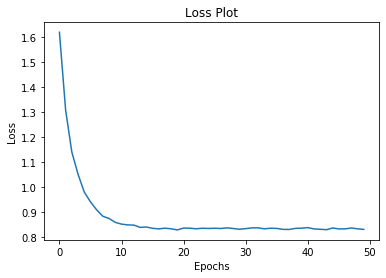

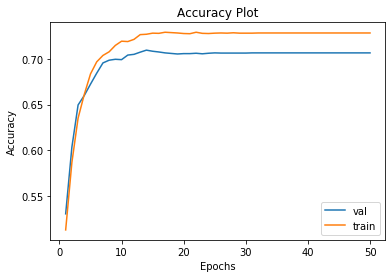

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7013    0.7630    0.7308      1000
           1     0.7895    0.8250    0.8068      1000
           2     0.6064    0.5130    0.5558      1000
           3     0.5854    0.4320    0.4971      1000
           4     0.6475    0.6320    0.6397      1000
           5     0.6047    0.5950    0.5998      1000
           6     0.6590    0.8580    0.7454      1000
           7     0.7350    0.7460    0.7404      1000
           8     0.7976    0.8000    0.7988      1000
           9     0.7577    0.7600    0.7589      1000

    accuracy                         0.6924     10000
   macro avg     0.6884    0.6924    0.6874     10000
weighted avg     0.6884    0.6924    0.6874     10000

Test accuracy 0.6924
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

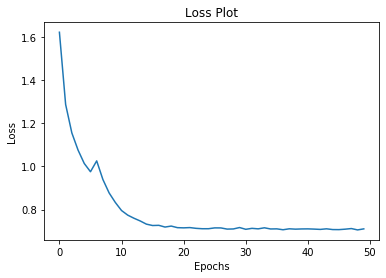

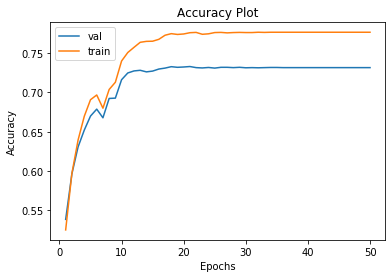

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7219    0.7970    0.7576      1000
           1     0.8142    0.8370    0.8254      1000
           2     0.6434    0.5810    0.6106      1000
           3     0.5876    0.4660    0.5198      1000
           4     0.6831    0.6640    0.6734      1000
           5     0.6448    0.6080    0.6258      1000
           6     0.6687    0.8700    0.7562      1000
           7     0.7750    0.7680    0.7715      1000
           8     0.8429    0.8210    0.8318      1000
           9     0.7891    0.7820    0.7855      1000

    accuracy                         0.7194     10000
   macro avg     0.7171    0.7194    0.7158     10000
weighted avg     0.7171    0.7194    0.7158     10000

Test accuracy 0.7194
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

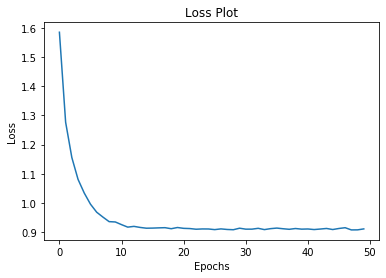

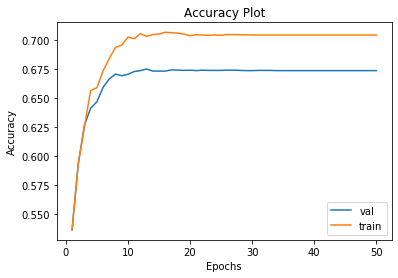

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6821    0.7510    0.7149      1000
           1     0.7602    0.8210    0.7894      1000
           2     0.6005    0.5140    0.5539      1000
           3     0.5693    0.4270    0.4880      1000
           4     0.6303    0.6070    0.6184      1000
           5     0.6048    0.5310    0.5655      1000
           6     0.6303    0.8370    0.7191      1000
           7     0.7190    0.7240    0.7215      1000
           8     0.7794    0.7810    0.7802      1000
           9     0.7343    0.7600    0.7469      1000

    accuracy                         0.6753     10000
   macro avg     0.6710    0.6753    0.6698     10000
weighted avg     0.6710    0.6753    0.6698     10000

Test accuracy 0.6753
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

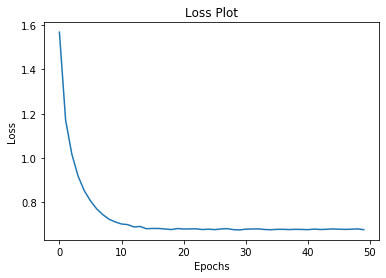

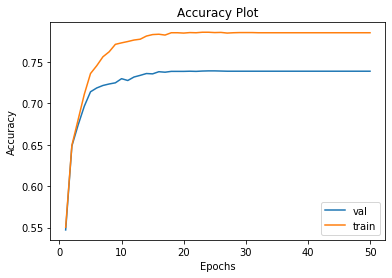

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7081    0.7810    0.7427      1000
           1     0.8166    0.8640    0.8397      1000
           2     0.6452    0.5710    0.6058      1000
           3     0.5916    0.4810    0.5306      1000
           4     0.7066    0.6190    0.6599      1000
           5     0.6430    0.6430    0.6430      1000
           6     0.6876    0.8450    0.7582      1000
           7     0.7584    0.7690    0.7637      1000
           8     0.8272    0.8280    0.8276      1000
           9     0.7855    0.8020    0.7937      1000

    accuracy                         0.7203     10000
   macro avg     0.7170    0.7203    0.7165     10000
weighted avg     0.7170    0.7203    0.7165     10000

Test accuracy 0.7203
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

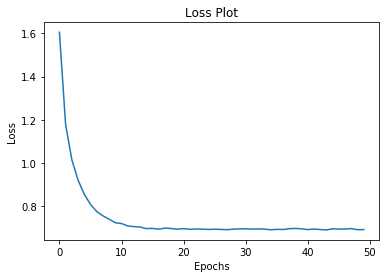

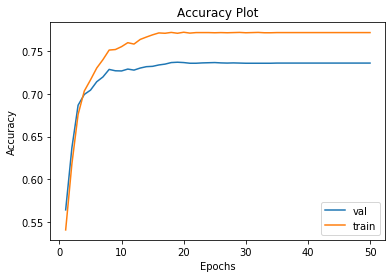

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7084    0.7700    0.7379      1000
           1     0.8176    0.8560    0.8363      1000
           2     0.6509    0.5630    0.6038      1000
           3     0.5959    0.4660    0.5230      1000
           4     0.6963    0.6650    0.6803      1000
           5     0.6368    0.6050    0.6205      1000
           6     0.6532    0.8700    0.7461      1000
           7     0.7582    0.7650    0.7616      1000
           8     0.8577    0.8260    0.8416      1000
           9     0.7970    0.8050    0.8010      1000

    accuracy                         0.7191     10000
   macro avg     0.7172    0.7191    0.7152     10000
weighted avg     0.7172    0.7191    0.7152     10000

Test accuracy 0.7191
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

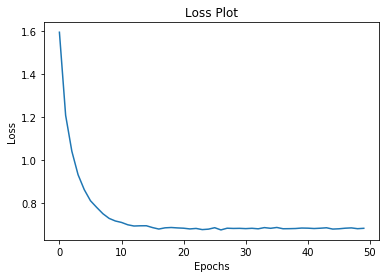

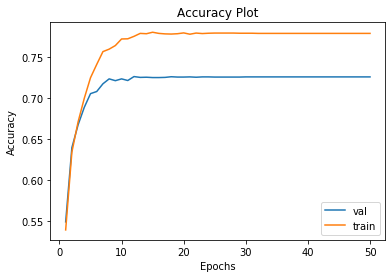

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7238    0.7940    0.7573      1000
           1     0.8089    0.8590    0.8332      1000
           2     0.6475    0.5730    0.6080      1000
           3     0.5924    0.4550    0.5147      1000
           4     0.6766    0.6610    0.6687      1000
           5     0.6235    0.6160    0.6197      1000
           6     0.6932    0.8540    0.7652      1000
           7     0.7510    0.7750    0.7628      1000
           8     0.8436    0.7930    0.8175      1000
           9     0.7743    0.7890    0.7816      1000

    accuracy                         0.7169     10000
   macro avg     0.7135    0.7169    0.7129     10000
weighted avg     0.7135    0.7169    0.7129     10000

Test accuracy 0.7169
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

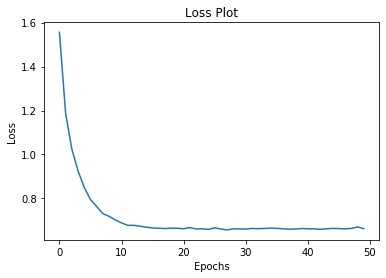

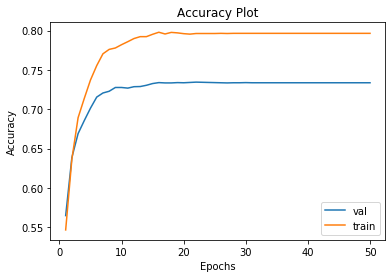

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7029    0.7950    0.7461      1000
           1     0.8253    0.8410    0.8331      1000
           2     0.6768    0.5780    0.6235      1000
           3     0.5756    0.4570    0.5095      1000
           4     0.6907    0.6810    0.6858      1000
           5     0.6348    0.5980    0.6159      1000
           6     0.6795    0.8460    0.7537      1000
           7     0.7592    0.7850    0.7719      1000
           8     0.8420    0.8260    0.8339      1000
           9     0.7811    0.7920    0.7865      1000

    accuracy                         0.7199     10000
   macro avg     0.7168    0.7199    0.7160     10000
weighted avg     0.7168    0.7199    0.7160     10000

Test accuracy 0.7199
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

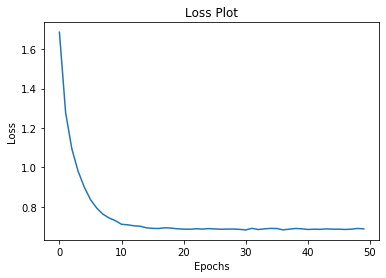

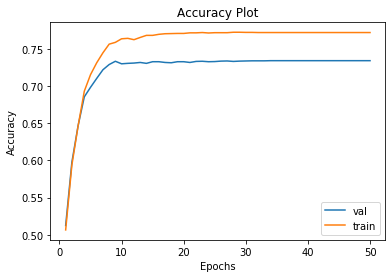

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7207    0.7820    0.7501      1000
           1     0.8287    0.8560    0.8421      1000
           2     0.6597    0.5720    0.6127      1000
           3     0.5754    0.4500    0.5051      1000
           4     0.6603    0.6590    0.6597      1000
           5     0.6332    0.6110    0.6219      1000
           6     0.6717    0.8450    0.7484      1000
           7     0.7799    0.7900    0.7849      1000
           8     0.8335    0.8110    0.8221      1000
           9     0.7846    0.8050    0.7947      1000

    accuracy                         0.7181     10000
   macro avg     0.7148    0.7181    0.7142     10000
weighted avg     0.7148    0.7181    0.7142     10000

Test accuracy 0.7181
------------------------------------
VGG Block 2 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

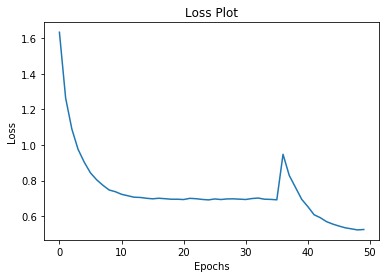

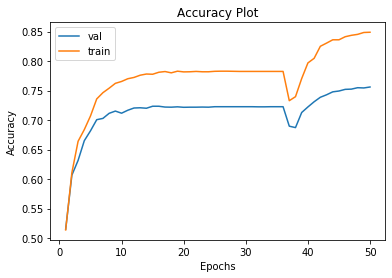

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7235    0.8060    0.7625      1000
           1     0.8428    0.8790    0.8605      1000
           2     0.6659    0.6120    0.6378      1000
           3     0.6477    0.5240    0.5793      1000
           4     0.7152    0.6830    0.6987      1000
           5     0.6741    0.6370    0.6550      1000
           6     0.7083    0.8790    0.7845      1000
           7     0.7937    0.7850    0.7893      1000
           8     0.8659    0.8460    0.8558      1000
           9     0.8185    0.8250    0.8217      1000

    accuracy                         0.7476     10000
   macro avg     0.7456    0.7476    0.7445     10000
weighted avg     0.7456    0.7476    0.7445     10000

Test accuracy 0.7476


In [0]:

  #Hyperparameters tuning on learning rate,batch size
for optimizer,rates in optimizers.items():
  for rate in rates:
    for batch_size in batch_size_list:
      for dropout in dropout_rates:
        print("------------------------------------")
        print("VGG Block 2 training")
        print("------------------------------------")
        print("ConvModel Training")
        print("HyperParameters")
        print("Batch size ",batch_size)
        print(optimizer," Optimizer initial rate ",rate)
        print("Dropout ",dropout)
        #datasets initialization
        CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
        exppath=path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
        os.makedirs(exppath,exist_ok=True)    
        # Model initialization
        model=ConvModel(filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=16,dropout=dropout)
        train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
        print("------------------------------------")
        print("Training....")
        print("------------------------------------")
        train_model(model,CIFAR,train_param)
        print("Test report saved in CIFAR folder and subfolder named as per parameters....")
        test_report(model,CIFAR,train_param)      

## Hyper Model 
Base hyper network- 3 into 3 and 16 into 16 channels base 




In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class HyperModel(tf.keras.Model):
  def __init__(self,emb_dim=4,emb_proj_dim=4,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=0.5):
    super(HyperModel, self).__init__()
    self.emb_dim=emb_dim
    self.emb_proj_dim=emb_proj_dim
    self.num_class=num_class
    self.base_channels=base_channels
    self.filter_size=filter_size
    # Hypernetwork
    self.hnet=HyperNetwork( Nz=emb_dim, D=emb_proj_dim , Nin=self.base_channels,Nout=self.base_channels,f=self.filter_size)
    self.hnet.build(input_shape=(None, emb_dim))
  
    #First Conv Block 
    self.conv1_1_layer = Conv2D(self.base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=self.base_channels,output_channels=self.base_channels,padding='SAME', activation='relu',name='hyper_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=0.4)    

    #Second Conv Block 
    self.conv2_1_hlayer = HyperConvLayer(hyper_net=self.hnet,input_channels=self.base_channels,output_channels=2*self.base_channels,padding='SAME', activation='relu',name='hyper_conv2_1')
    self.conv2_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=2*self.base_channels,output_channels=2*self.base_channels,padding='SAME', activation='relu',name='hyper_conv2_2')
    self.batch2_layer=BatchNormalization(name='main_batch2')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')
    self.dropout2_layer=Dropout(rate=0.4)    

    self.flatten_layer=Flatten()
    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout_dense1_layer=Dropout(rate=dropout)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')
    

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_hlayer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    
    #second block
    conv2_1_outputs=self.conv2_1_hlayer(dropout1_outputs)
    conv2_2_outputs=self.conv2_2_hlayer(conv2_1_outputs)
    batch2_outputs=self.batch2_layer(conv2_2_outputs)
    max2_outputs=self.max2_layer(batch2_outputs)
    dropout2_outputs=self.dropout2_layer(max2_outputs)
    flatten=self.flatten_layer(dropout2_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout_dense1_outputs=self.dropout_dense1_layer(dense1_outputs)
    prob=self.final_layer(dropout_dense1_outputs)
    return prob

In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block2'
name='hypermodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

# emb_proj_list=[(4,4),(6,6),(8,8),(16,16)]
emb_proj_list=[(8,16)]
batch_size_list=[128]
dropout_rates=[0.5]
optimizers={'adam':[0.001]}
epochs=50


------------------------------------
VGG Block 2 training
------------------------------------
Hypermodel Training
Embedding size  8
Projection Embedding size  16
HyperParameters
Batch size  128
Dropout  0.5
adam  Optimizer initial rate  0.001
------------------------------------
Training....
------------------------------------
Epoch 6 Loss 1.3949 Train Accuracy 0.5502 Val Accuracy 0.5266
Epoch 7 Loss 1.3234 Train Accuracy 0.5702 Val Accuracy 0.5578
Epoch 8 Loss 1.2709 Train Accuracy 0.5906 Val Accuracy 0.5666
Epoch 9 Loss 1.2336 Train Accuracy 0.5940 Val Accuracy 0.5744
Epoch 10 Loss 1.2037 Train Accuracy 0.6064 Val Accuracy 0.5798
Epoch 11 Loss 1.1849 Train Accuracy 0.6184 Val Accuracy 0.5828
Epoch 12 Loss 1.1657 Train Accuracy 0.6188 Val Accuracy 0.5848
Epoch 13 Loss 1.1539 Train Accuracy 0.6198 Val Accuracy 0.5830
Epoch 14 Loss 1.1449 Train Accuracy 0.6256 Val Accuracy 0.5886
Epoch 15 Loss 1.1372 Train Accuracy 0.6274 Val Accuracy 0.5892
Epoch 16 Loss 1.1363 Train Accuracy 0.6284 

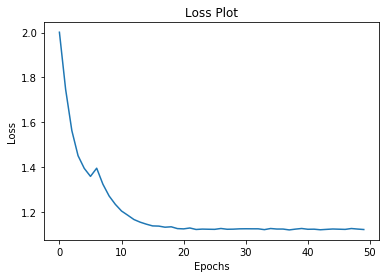

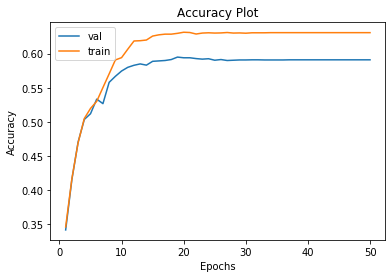

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6094    0.6740    0.6401      1000
           1     0.6700    0.7270    0.6974      1000
           2     0.5051    0.4450    0.4732      1000
           3     0.4610    0.3370    0.3894      1000
           4     0.5198    0.4720    0.4948      1000
           5     0.5323    0.5020    0.5167      1000
           6     0.6076    0.7310    0.6636      1000
           7     0.6256    0.6750    0.6494      1000
           8     0.6726    0.7170    0.6941      1000
           9     0.6363    0.6350    0.6356      1000

    accuracy                         0.5915     10000
   macro avg     0.5840    0.5915    0.5854     10000
weighted avg     0.5840    0.5915    0.5854     10000

Test accuracy 0.5915


In [0]:
for emb_dim,emb_proj_dim in emb_proj_list:
  model_path=path+'/emb_'+str(emb_dim)+'_proj_'+str(emb_proj_dim)
  for optimizer,rates in optimizers.items():
    for rate in rates:
      for batch_size in batch_size_list:
        for dropout in dropout_rates:
          print("------------------------------------")
          print("VGG Block 2 training")
          print("------------------------------------")
          print("Hypermodel Training")
          print("Embedding size ",emb_dim)
          print("Projection Embedding size ",emb_proj_dim)
          print("HyperParameters")
          print("Batch size ",batch_size)
          print("Dropout ",dropout)
          print(optimizer," Optimizer initial rate ",rate)
          #datasets initialization
          CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
          exppath=model_path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
          os.makedirs(exppath,exist_ok=True)    
          # Model initialization
          model=HyperModel(emb_dim=emb_dim,emb_proj_dim=emb_proj_dim,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=dropout)
          train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
          print("------------------------------------")
          print("Training....")
          print("------------------------------------")
          train_model(model,CIFAR,train_param)
          print("Test report saved in CIFAR folder and subfolder named as per parameters....")
          test_report(model,CIFAR,train_param)       

# Third Architecture- Three VGG Block
conv 16 3,3 \\
conv 16 3,3 \\
max pool 2,2 \\
dropout 0.4 \\
conv 32 3,3 \\
conv 32 3,3 \\
max pool 2,2 \\
dropout 0.4 \\
dropout 0.4 \\
conv 64 3,3 \\
conv 64 3,3 \\
max pool 2,2 \\
dense 128 \\
dropout hp \\
dense 10

In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class ConvModel(tf.keras.Model):
  def __init__(self,filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=32,dropout=0.5):
    super(ConvModel, self).__init__()
    self.num_class=num_class
    self.filter_size=filter_size
    
    #First Conv Block 
    self.conv1_1_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_layer = Conv2D(base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=0.4)    
    #Second Conv Block 
    self.conv2_1_layer = Conv2D(2*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu',name='main_conv2_1')
    self.conv2_2_layer = Conv2D(2*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv2_2')
    self.batch2_layer=BatchNormalization(name='main_batch2')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')
    self.dropout2_layer=Dropout(rate=0.4)
    #Second Conv Block 
    self.conv3_1_layer = Conv2D(4*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu',name='main_conv3_1')
    self.conv3_2_layer = Conv2D(4*base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', name='main_conv3_2')
    self.batch3_layer=BatchNormalization(name='main_batch3')
    self.max3_layer=MaxPool2D(pool_size=(2,2),name='main_max3')
    self.dropout3_layer=Dropout(rate=0.4)
    self.flatten_layer=Flatten()

    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout_dense1_layer=Dropout(rate=dropout)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_layer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    #second block
    conv2_1_outputs=self.conv2_1_layer(dropout1_outputs)
    conv2_2_outputs=self.conv2_2_layer(conv2_1_outputs)
    batch2_outputs=self.batch2_layer(conv2_2_outputs)
    max2_outputs=self.max2_layer(batch2_outputs)
    dropout2_outputs=self.dropout2_layer(max2_outputs)
    #Third block
    conv3_1_outputs=self.conv3_1_layer(dropout2_outputs)
    conv3_2_outputs=self.conv3_2_layer(conv3_1_outputs)
    batch3_outputs=self.batch3_layer(conv3_2_outputs)
    max3_outputs=self.max3_layer(batch3_outputs)
    dropout3_outputs=self.dropout3_layer(max3_outputs)

    flatten=self.flatten_layer(dropout3_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout_dense1_outputs=self.dropout_dense1_layer(dense1_outputs)
    prob=self.final_layer(dropout_dense1_outputs)
    return prob

In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block3'
name='convmodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

batch_size_list=[128]
dropout_rates=[0.3,0.5,0.7]
optimizers={'adam':[0.001,0.003,0.005]}
epochs=50

------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  128
adam  Optimizer initial rate  0.001
Dropout  0.3
------------------------------------
Training....
------------------------------------
Best validation accuracy 0.7342
Model: "conv_model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_conv1_1 (Conv2D)        multiple                  448       
_________________________________________________________________
main_conv1_2 (Conv2D)        multiple                  2320      
_________________________________________________________________
main_batch1 (BatchNormalizat multiple                  64        
_________________________________________________________________
main_max1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
dro

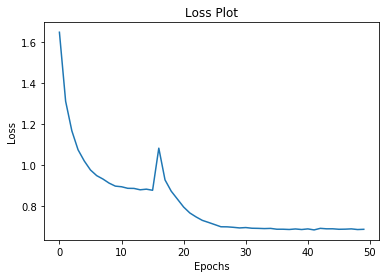

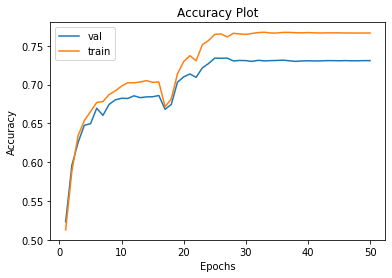

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7261    0.7900    0.7567      1000
           1     0.8264    0.8520    0.8390      1000
           2     0.6583    0.6030    0.6294      1000
           3     0.5911    0.4640    0.5199      1000
           4     0.7176    0.6760    0.6962      1000
           5     0.6456    0.6430    0.6443      1000
           6     0.6889    0.8770    0.7717      1000
           7     0.7823    0.7620    0.7720      1000
           8     0.8295    0.8220    0.8257      1000
           9     0.7908    0.7940    0.7924      1000

    accuracy                         0.7283     10000
   macro avg     0.7257    0.7283    0.7247     10000
weighted avg     0.7257    0.7283    0.7247     10000

Test accuracy 0.7283
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

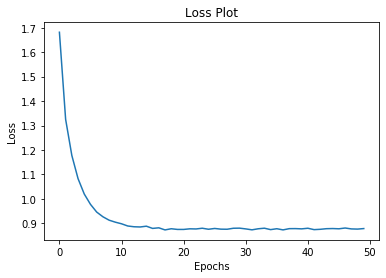

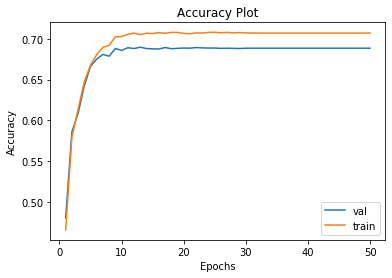

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7143    0.7800    0.7457      1000
           1     0.7756    0.7640    0.7698      1000
           2     0.5998    0.5050    0.5483      1000
           3     0.5370    0.4140    0.4675      1000
           4     0.6408    0.6190    0.6297      1000
           5     0.6346    0.5870    0.6099      1000
           6     0.6264    0.8450    0.7195      1000
           7     0.7540    0.7450    0.7495      1000
           8     0.7921    0.8040    0.7980      1000
           9     0.6992    0.7460    0.7218      1000

    accuracy                         0.6809     10000
   macro avg     0.6774    0.6809    0.6760     10000
weighted avg     0.6774    0.6809    0.6760     10000

Test accuracy 0.6809
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

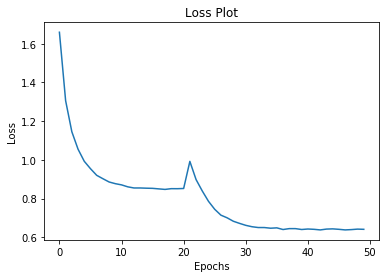

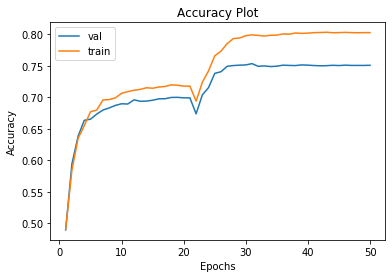

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7220    0.8000    0.7590      1000
           1     0.8341    0.8650    0.8493      1000
           2     0.6780    0.5770    0.6234      1000
           3     0.6365    0.4920    0.5550      1000
           4     0.6986    0.6860    0.6922      1000
           5     0.6450    0.6450    0.6450      1000
           6     0.6826    0.8730    0.7661      1000
           7     0.7888    0.7880    0.7884      1000
           8     0.8476    0.8290    0.8382      1000
           9     0.8117    0.8060    0.8088      1000

    accuracy                         0.7361     10000
   macro avg     0.7345    0.7361    0.7326     10000
weighted avg     0.7345    0.7361    0.7326     10000

Test accuracy 0.7361
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

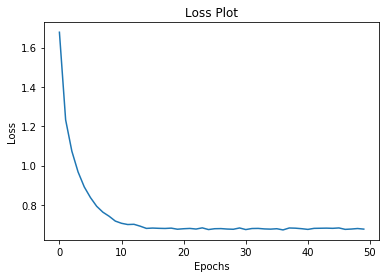

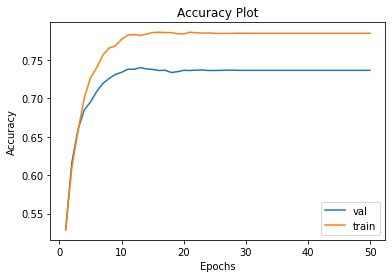

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7002    0.7730    0.7348      1000
           1     0.8034    0.8580    0.8298      1000
           2     0.6655    0.5730    0.6158      1000
           3     0.6036    0.4750    0.5316      1000
           4     0.6734    0.6680    0.6707      1000
           5     0.6464    0.6180    0.6319      1000
           6     0.6981    0.8510    0.7670      1000
           7     0.7692    0.7730    0.7711      1000
           8     0.8467    0.8230    0.8347      1000
           9     0.7606    0.7880    0.7741      1000

    accuracy                         0.7200     10000
   macro avg     0.7167    0.7200    0.7161     10000
weighted avg     0.7167    0.7200    0.7161     10000

Test accuracy 0.7200
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

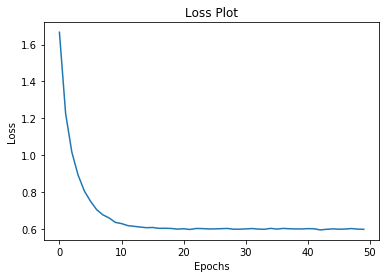

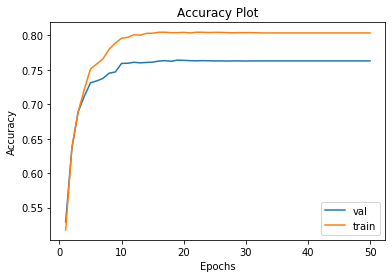

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7341    0.7840    0.7582      1000
           1     0.8454    0.8640    0.8546      1000
           2     0.6767    0.5820    0.6258      1000
           3     0.5936    0.5010    0.5434      1000
           4     0.7092    0.7000    0.7046      1000
           5     0.6727    0.6350    0.6533      1000
           6     0.6915    0.8830    0.7756      1000
           7     0.7926    0.7910    0.7918      1000
           8     0.8532    0.8250    0.8388      1000
           9     0.8074    0.8340    0.8205      1000

    accuracy                         0.7399     10000
   macro avg     0.7376    0.7399    0.7367     10000
weighted avg     0.7376    0.7399    0.7367     10000

Test accuracy 0.7399
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

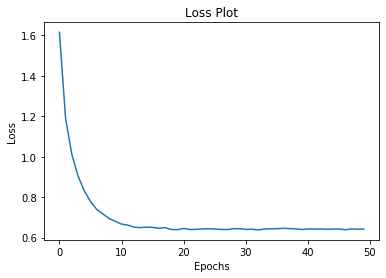

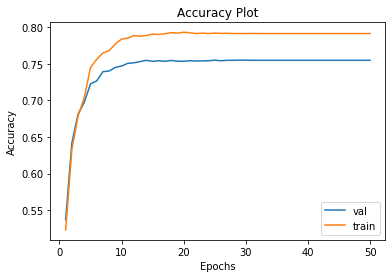

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7339    0.8000    0.7656      1000
           1     0.8476    0.8840    0.8654      1000
           2     0.6562    0.6050    0.6296      1000
           3     0.5860    0.5010    0.5402      1000
           4     0.7159    0.6830    0.6991      1000
           5     0.6396    0.6300    0.6348      1000
           6     0.7176    0.8640    0.7840      1000
           7     0.8025    0.7760    0.7890      1000
           8     0.8497    0.8310    0.8402      1000
           9     0.8293    0.8310    0.8302      1000

    accuracy                         0.7405     10000
   macro avg     0.7378    0.7405    0.7378     10000
weighted avg     0.7378    0.7405    0.7378     10000

Test accuracy 0.7405
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

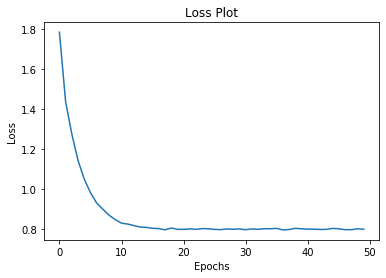

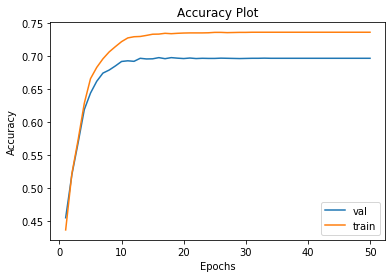

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.6859    0.7360    0.7101      1000
           1     0.7970    0.7890    0.7930      1000
           2     0.5891    0.5420    0.5646      1000
           3     0.5317    0.4360    0.4791      1000
           4     0.6400    0.5850    0.6113      1000
           5     0.5877    0.5830    0.5853      1000
           6     0.6977    0.8240    0.7556      1000
           7     0.6991    0.7320    0.7152      1000
           8     0.7971    0.7780    0.7874      1000
           9     0.7157    0.7780    0.7456      1000

    accuracy                         0.6783     10000
   macro avg     0.6741    0.6783    0.6747     10000
weighted avg     0.6741    0.6783    0.6747     10000

Test accuracy 0.6783
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

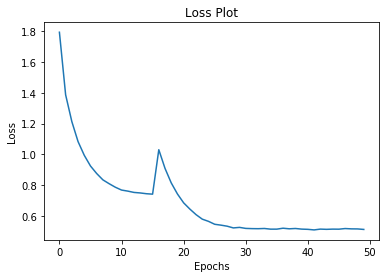

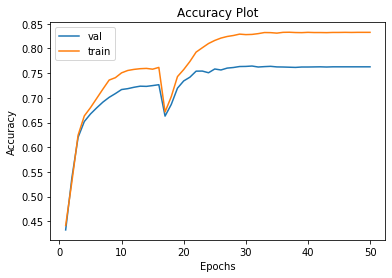

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7472    0.7950    0.7703      1000
           1     0.8691    0.8830    0.8760      1000
           2     0.6652    0.6100    0.6364      1000
           3     0.6095    0.4980    0.5482      1000
           4     0.7099    0.6950    0.7024      1000
           5     0.6893    0.6590    0.6738      1000
           6     0.7093    0.8810    0.7859      1000
           7     0.8050    0.8010    0.8030      1000
           8     0.8675    0.8380    0.8525      1000
           9     0.8073    0.8460    0.8262      1000

    accuracy                         0.7506     10000
   macro avg     0.7479    0.7506    0.7475     10000
weighted avg     0.7479    0.7506    0.7475     10000

Test accuracy 0.7506
------------------------------------
VGG Block 3 training
------------------------------------
ConvModel Training
HyperParameters
Batch size  12

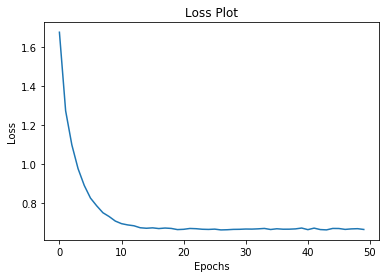

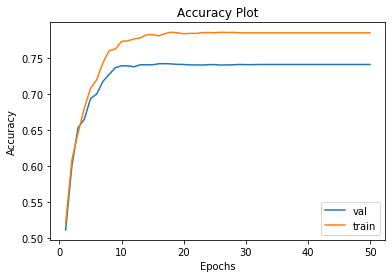

Test report saved in CIFAR folder and subfolder named as per parameters....
              precision    recall  f1-score   support

           0     0.7326    0.7890    0.7597      1000
           1     0.8652    0.8600    0.8626      1000
           2     0.6442    0.5830    0.6121      1000
           3     0.5563    0.4790    0.5148      1000
           4     0.6931    0.6730    0.6829      1000
           5     0.6345    0.6110    0.6225      1000
           6     0.7097    0.8460    0.7719      1000
           7     0.7856    0.7770    0.7813      1000
           8     0.8377    0.8360    0.8368      1000
           9     0.7933    0.8330    0.8127      1000

    accuracy                         0.7287     10000
   macro avg     0.7252    0.7287    0.7257     10000
weighted avg     0.7252    0.7287    0.7257     10000

Test accuracy 0.7287


In [0]:

  #Hyperparameters tuning on learning rate,batch size
for optimizer,rates in optimizers.items():
  for rate in rates:
    for batch_size in batch_size_list:
      for dropout in dropout_rates:
        print("------------------------------------")
        print("VGG Block 3 training")
        print("------------------------------------")
        print("ConvModel Training")
        print("HyperParameters")
        print("Batch size ",batch_size)
        print(optimizer," Optimizer initial rate ",rate)
        print("Dropout ",dropout)
        #datasets initialization
        CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
        exppath=path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
        os.makedirs(exppath,exist_ok=True)    
        # Model initialization
        model=ConvModel(filter_size=3,input_shape=(32,32,3),num_class=10,base_channels=16,dropout=dropout)
        train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
        print("------------------------------------")
        print("Training....")
        print("------------------------------------")
        train_model(model,CIFAR,train_param)
        print("Test report saved in CIFAR folder and subfolder named as per parameters....")
        test_report(model,CIFAR,train_param)      

## Hyper Model 
Base hyper network- 3 into 3 and 16 into 16 channels base 




In [0]:

'''
  Parameters-
  input_shape=(height,width,channels)
'''
class HyperModel(tf.keras.Model):
  def __init__(self,emb_dim=4,emb_proj_dim=4,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=0.5):
    super(HyperModel, self).__init__()
    self.emb_dim=emb_dim
    self.emb_proj_dim=emb_proj_dim
    self.num_class=num_class
    self.base_channels=base_channels
    self.filter_size=filter_size
    # Hypernetwork
    self.hnet=HyperNetwork( Nz=emb_dim, D=emb_proj_dim , Nin=self.base_channels,Nout=self.base_channels,f=self.filter_size)
    self.hnet.build(input_shape=(None, emb_dim))
  
    #First Conv Block 
    self.conv1_1_layer = Conv2D(self.base_channels,  [self.filter_size,self.filter_size], kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=input_shape,name='main_conv1_1')
    self.conv1_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=self.base_channels,output_channels=self.base_channels,padding='SAME', activation='relu',name='hyper_conv1_2')
    self.batch1_layer=BatchNormalization(name='main_batch1')
    self.max1_layer=MaxPool2D(pool_size=(2,2),name='main_max1')
    self.dropout1_layer=Dropout(rate=0.4)    

    #Second Conv Block 
    self.conv2_1_hlayer = HyperConvLayer(hyper_net=self.hnet,input_channels=self.base_channels,output_channels=2*self.base_channels,padding='SAME', activation='relu',name='hyper_conv2_1')
    self.conv2_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=2*self.base_channels,output_channels=2*self.base_channels,padding='SAME', activation='relu',name='hyper_conv2_2')
    self.batch2_layer=BatchNormalization(name='main_batch2')
    self.max2_layer=MaxPool2D(pool_size=(2,2),name='main_max2')
    self.dropout2_layer=Dropout(rate=0.4)    

    #Third Conv Block 
    self.conv3_1_hlayer = HyperConvLayer(hyper_net=self.hnet,input_channels=2*self.base_channels,output_channels=4*self.base_channels,padding='SAME', activation='relu',name='hyper_conv3_1')
    self.conv3_2_hlayer=HyperConvLayer(hyper_net=self.hnet,input_channels=4*self.base_channels,output_channels=4*self.base_channels,padding='SAME', activation='relu',name='hyper_conv3_2')
    self.batch3_layer=BatchNormalization(name='main_batch3')
    self.max3_layer=MaxPool2D(pool_size=(2,2),name='main_max3')
    self.dropout3_layer=Dropout(rate=0.4)
    self.flatten_layer=Flatten()
    #Dense layer
    self.dense1_layer=Dense(units=128,name='dense1', activation='relu', kernel_initializer='he_uniform')
    self.dropout_dense1_layer=Dropout(rate=dropout)
    self.final_layer=Dense(units=num_class, activation='softmax',name='dense2')
    

  def call(self, x):
    conv1_1_outputs=self.conv1_1_layer(x)
    conv1_2_outputs=self.conv1_2_hlayer(conv1_1_outputs)
    batch1_outputs=self.batch1_layer(conv1_2_outputs)
    max1_outputs=self.max1_layer(batch1_outputs)
    dropout1_outputs=self.dropout1_layer(max1_outputs)
    
    #second block
    conv2_1_outputs=self.conv2_1_hlayer(dropout1_outputs)
    conv2_2_outputs=self.conv2_2_hlayer(conv2_1_outputs)
    batch2_outputs=self.batch2_layer(conv2_2_outputs)
    max2_outputs=self.max2_layer(batch2_outputs)
    dropout2_outputs=self.dropout2_layer(max2_outputs)

    #second block
    conv3_1_outputs=self.conv3_1_hlayer(dropout2_outputs)
    conv3_2_outputs=self.conv3_2_hlayer(conv3_1_outputs)
    batch3_outputs=self.batch3_layer(conv3_2_outputs)
    max3_outputs=self.max3_layer(batch3_outputs)
    dropout3_outputs=self.dropout3_layer(max3_outputs)
    
    flatten=self.flatten_layer(dropout3_outputs)
    dense1_outputs=self.dense1_layer(flatten)
    dropout2_outputs=self.dropout_dense1_layer(dense1_outputs)
    prob=self.final_layer(dropout2_outputs)
    return prob

In [0]:
# Hyper paramter tuning list
dataset='CIFAR'
model_type='VGG_block3'
name='hypermodel'
path=dataset+'/'+model_type+'/'+name
os.makedirs(path,exist_ok=True)

# emb_proj_list=[(8,8),] 16 
emb_proj_list=[(16,16),(32,32)]
batch_size_list=[128]
dropout_rates=[0.7]
optimizers={'adam':[0.001]}
epochs=50


In [0]:
for emb_dim,emb_proj_dim in emb_proj_list:
  model_path=path+'/emb_'+str(emb_dim)+'_proj_'+str(emb_proj_dim)
  for optimizer,rates in optimizers.items():
    for rate in rates:
      for batch_size in batch_size_list:
        for dropout in dropout_rates:
          print("------------------------------------")
          print("VGG Block 3 training")
          print("------------------------------------")
          print("Hypermodel Training")
          print("Embedding size ",emb_dim)
          print("Projection Embedding size ",emb_proj_dim)
          print("HyperParameters")
          print("Batch size ",batch_size)
          print("Dropout ",dropout)
          print(optimizer," Optimizer initial rate ",rate)
          #datasets initialization
          CIFAR=read_data_sets( x_train[:45000],y_train[:45000],x_train[45000:],y_train[45000:],x_test, y_test)
          exppath=model_path+'/'+optimizer+'_rate_'+str(rate)+'_batch_'+str(batch_size)+'_dropout_'+str(dropout)+'/'  
          os.makedirs(exppath,exist_ok=True)    
          # Model initialization
          model=HyperModel(emb_dim=emb_dim,emb_proj_dim=emb_proj_dim,filter_size=3,input_shape=(28,28,3),num_class=10,base_channels=16,dropout=dropout)
          train_param=train_parameters(batch_size=batch_size,optimizer=optimizer,num_epochs=epochs,learning_rate=rate,rate_decay=0.999,savepath=exppath)
          print("------------------------------------")
          print("Training....")
          print("------------------------------------")
          train_model(model,CIFAR,train_param)
          print("Test report saved in CIFAR folder and subfolder named as per parameters....")
          test_report(model,CIFAR,train_param)       

------------------------------------
VGG Block 3 training
------------------------------------
Hypermodel Training
Embedding size  16
Projection Embedding size  16
HyperParameters
Batch size  128
Dropout  0.7
adam  Optimizer initial rate  0.001
------------------------------------
Training....
------------------------------------
Epoch 0 Loss 2.0869 Train Accuracy 0.2854 Val Accuracy 0.2706
Epoch 1 Loss 1.9297 Train Accuracy 0.3176 Val Accuracy 0.3110
Epoch 2 Loss 1.8523 Train Accuracy 0.3266 Val Accuracy 0.3254
Epoch 3 Loss 1.8241 Train Accuracy 0.3366 Val Accuracy 0.3428
Epoch 4 Loss 1.8022 Train Accuracy 0.3490 Val Accuracy 0.3504
Epoch 5 Loss 1.7902 Train Accuracy 0.3514 Val Accuracy 0.3504
Epoch 6 Loss 1.7827 Train Accuracy 0.3540 Val Accuracy 0.3538
Epoch 7 Loss 1.7775 Train Accuracy 0.3548 Val Accuracy 0.3550
Epoch 8 Loss 1.7751 Train Accuracy 0.3546 Val Accuracy 0.3570
Epoch 9 Loss 1.7713 Train Accuracy 0.3566 Val Accuracy 0.3594
Epoch 10 Loss 1.7698 Train Accuracy 0.3572 Val A